# Milestone 1
<p> Mark Lisi<br>
Sarper Tutuncuoglu </p>

[GitHub.io Link](marklisi1.github.io)
***

Our group plans to investigate patterns in job applications and hiring in the city of New Orleans. We plan to focus predominantly on New Orleans City Service Departments in our analysis. 
	

The first dataset we have found describes [hiring data for city jobs in New Orleans.](https://data.nola.gov/City-Administration/City-Jobs-Hiring-Data/wx2k-rsac/data) We took this dataset from data.nola.gov. The dataset contains information about the job title/department, as well as the term length of the hire. One of the trends that we hope to further explore is a relationship between hire length and type of job. We believe that probationary hires may be unfairly exploited based on the easily terminable nature of their hiring terms. 
	

In [2]:
import pandas as pd

hiring_df = pd.read_csv("./data/City_Jobs_Hiring_Data.csv")
hiring_df.head()


,Start_Date,Job_Title,Department,Department_Code,Job_Term,List_Type,Req_Number,Appointment_Type
0,01/13/2020 06:00:00 AM,"OFFICE ASSISTANT, TRAINEE (CLASS CODE 0020)",Office Of Community Development,719,Probationary,Regular and Promotional,2019-02185,New Hire/Rehire
1,02/23/2020 12:00:00 AM,"OFFICE ASSISTANT, TRAINEE (CLASS CODE 0020)",Property Management,450,Probationary,Regular and Promotional,2020-00541,New Hire/Rehire
2,01/19/2020 12:00:00 AM,POLICE AIDE (CLASS CODE 7105),Police Department,270,Probationary,Regular,2020-00088,New Hire/Rehire
3,03/01/2020 12:00:00 AM,POLICE AIDE (CLASS CODE 7105),Police Department,270,Provisional,Regular,2020-00628,New Hire/Rehire
4,03/15/2020 12:00:00 AM,POLICE AIDE (CLASS CODE 7105),Police Department,270,Provisional,Regular,2020-00645,New Hire/Rehire


Luckily, most of the data on data.nola.gov is already tidy. We can also observe that our only numerical variable, Start_Date, has a value in every entry. 

In [3]:
hiring_df[hiring_df["Start_Date"].isnull()]

,Start_Date,Job_Title,Department,Department_Code,Job_Term,List_Type,Req_Number,Appointment_Type


Because of this, we do not need to worry about NaNs. However, this dataset does have a few limitations. Firstly, it is not very large - if we hope to draw any widely applicable conclusions, we will need to find a bigger source of data. However, we believe that the trends which emerge in this dataset will help point us in the right direction for the rest of our project. Additionally, it lacks some demographic statistics that might generate more powerful conclusions - the pay of each job, the race and gender of the applicant, etc. We hope to gain insight on these topics by crossreferencing this dataset with others - potentially IRS/FRED data.
	

Another dataset we are considering working with is [city job applications.](https://data.nola.gov/City-Administration/City-Job-Applications-Submitted/ewwx-j8eu/data)

In [4]:
application_df = pd.read_csv("./data/City_Job_Applications_Submitted.csv")
application_df.head()

,City Job Title,Application Date
0,311 TELECOMMUNICATIONS OPERATOR (CLASS CODE 7401),02/16/2018 12:00:00 AM
1,311 TELECOMMUNICATIONS OPERATOR (CLASS CODE 7401),02/16/2018 12:00:00 AM
2,311 TELECOMMUNICATIONS OPERATOR (CLASS CODE 7401),02/16/2018 12:00:00 AM
3,311 TELECOMMUNICATIONS OPERATOR (CLASS CODE 7401),02/16/2018 12:00:00 AM
4,311 TELECOMMUNICATIONS OPERATOR (CLASS CODE 7401),02/16/2018 12:00:00 AM


 This dataset doesn’t give us much - simply the title of the job applied for and the time of application - but it is considerably larger than the first dataset. We can at least determine which jobs are most frequently applied to at different times of year using this dataset.
	

For our collaboration plan, we are primarily using a combination of Github and Zoom meetings. We both have experience using Github to coordinate code in group projects, so we should be able to maintain an organized work environment. We have been meeting over Zoom on Sundays to touch base about work scheduling, but we are both able to have relatively flexible meeting patterns as the semester progresses.

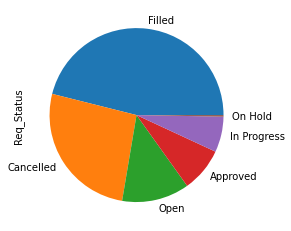

In [15]:
req_df = pd.read_csv("./data/City_Jobs_Requisition_Requests.csv")
req_df['Req_Status'].value_counts().plot.pie()